In [1]:
%matplotlib inline

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scanpy as sc

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1#0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
# load old data
adata = sc.read('/home/ngr4/project/scnd/data/processed/mouse_210726.h5ad')

In [3]:
# aesthetics
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE',
            'Deep cerebellar nuclei': '#aaaaaa'}

In [4]:
pfp = '/home/ngr4/project/scnd/results/'

savefigs = True

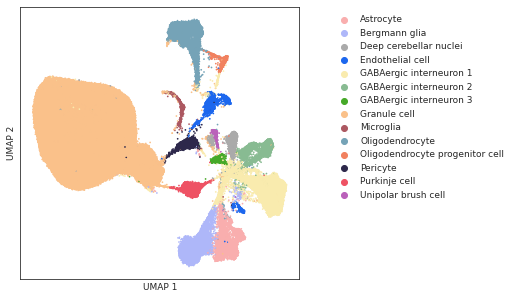

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                hue=adata.obs['ctype_ubcupdate'],
                linewidth=0,
                s=3,
                palette=cmap_ctype,
                rasterized=True)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

if savefigs:
    fig.savefig(os.path.join(pfp, 'umap_mouse_updated_ctypes.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False

In [ ]:
savefigs = True

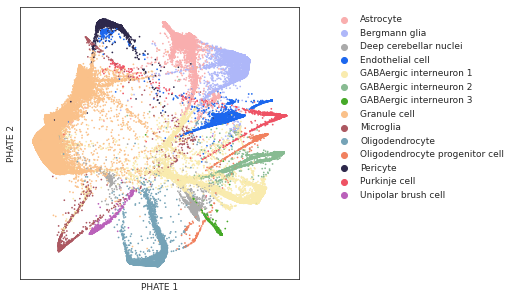

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=adata.obsm['X_phate'][:, 0],
                y=adata.obsm['X_phate'][:, 1],
                hue=adata.obs['ctype_ubcupdate'],
                linewidth=0,
                s=3,
                palette=cmap_ctype,
                rasterized=True)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')

if savefigs:
    fig.savefig(os.path.join(pfp, 'phate_mouse_updated_ctypes.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False

# color by goi

In [5]:
# load imputed data
def imp_goi_to_adata(adata, goi, return_imputed_adatas=False, **kwargs):
    '''Add imputed expression to adata.obs metadata for plotting.
    
    Assumes indices match in adata, wt, and mut.
    
    Arguments:
      adata (sc.AnnData)
      goi (list)
      
    Returns:
      adata: copy of adata with genes of interest imputed expression in adata.obs column with Gene (imputed)
    '''
    if not 'wt' in kwargs:
        wt = sc.read('/home/ngr4/project/scnd/data/processed/mouse_wt_imputed.h5ad')
    else:
        wt = kwargs['wt']
    if not 'mut' in kwargs:
        # option to not supply both
        mut = sc.read('/home/ngr4/project/scnd/data/processed/mouse_sca1_imputed.h5ad')
    else:
        mut = kwargs['mut']
    
    for i, g in enumerate(goi):
        wt.obs['{} (imputed)'.format(g)] = np.asarray(wt[:, g].layers['imputed']).flatten()
        mut.obs['{} (imputed)'.format(g)] = np.asarray(mut[:, g].layers['imputed']).flatten()
        adata.obs = adata.obs.merge(wt.obs['{} (imputed)'.format(g)].append(mut.obs['{} (imputed)'.format(g)]), 
                                    how='left', left_index=True, right_index=True)
    
    if return_imputed_adatas:
        return adata, wt, mut
    else:
        return adata
    

In [6]:
adata = imp_goi_to_adata(adata, ['Eomes'], return_imputed_adatas=False)

In [25]:
savefigs  = True
wcbar = True
g = 'Eomes'

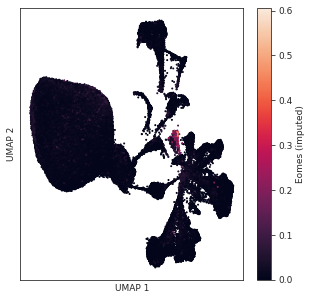

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = ax.scatter(adata.obsm['X_umap'][:, 0],
           adata.obsm['X_umap'][:, 1], 
           c=adata.obs['{} (imputed)'.format(g)], 
           s=1, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

if wcbar:
    cbar = fig.colorbar(im)
    cbar.set_label('{} (imputed)'.format(g))
    
if savefigs:
    if wcbar:
        fig.savefig(os.path.join(pfp, 'umap_mouse_Eomes_imp_cbar.pdf'), bbox_inches='tight', dpi=600)
    else:
        fig.savefig(os.path.join(pfp, 'umap_mouse_Eomes_imp.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False

In [10]:
savefigs = True

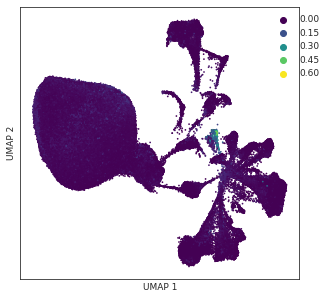

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = sns.scatterplot(x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                hue=adata.obs['Eomes (imputed)'],
                linewidth=0,
                s=3,
                palette=plt.cm.viridis,
                rasterized=True,
                    ax = ax)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

if savefigs:
    fig.savefig(os.path.join(pfp, 'umap_mouse_updated_ctypes.pdf'), bbox_inches='tight', dpi=600)
    savefigs = False